# Tutorial-5: Monte Carlo simulation with SU(N) coherent states on triangular lattice XXZ+D model with spin-1

In [1]:
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import SpinToolkit_py as sptk

## Define a triangular lattice to be used

In [2]:
sptk.print_system_info()
latt = sptk.lattice(name = "triangular", L = [42, 42])

Hostname:                dell3660
CPU Type:                12th Gen Intel(R) Core(TM) i9-12900
Thread count:            16
Platform:                linux
Time Now:                2025-10-25---16:29:26.173---CST

OMP version:             202011
OMP bind policy:         false
OMP number of procs:     16
OMP number of threads:   1
OMP number of devices:   0

Boost lib version:       1_83
NLopt version:           2.7.1
SPGlib version:          2.3.1
SpinToolkit Compiled by: Clang version 21.0.0git (icx 2025.2.0.20250806) (-O1, -O2, -O3) on Oct 25 2025
SpinToolkit version:     1.1.0

Triangular lattice built.
Nsites   = 1764
num_sub  = 1
dim      = 2
Real space basis (a):                              
a0: [                   1                   0]
a1: [                -0.5           0.8660254]
Reciprocal space basis (b / 2π):                   
b0: [                   1           0.5773503]
b1: [                   0            1.154701]
Superlattice real space basis (A) [unit: a]:       
A0

## Define the model and include magnetic couplings

In [3]:
J = 1.0               # nearest-neighbor exchange
K = -1.5              # biquadratic interaction on nearest-neighbor bonds

hamiltonian = sptk.model_spin(S = 1.0, mode = "SU(N)", lattice = latt)
print()

Nsites = latt.Nsites()
for site_i in range(Nsites):
    coor_i, sub_i = latt.site2coor(site = site_i)
    coor0_i, Mi   = latt.coor2supercell0(coor = coor_i)
    xi = coor_i[0]
    yi = coor_i[1]

    coor_j      = [xi + 1, yi]
    coor0_j, Mj = latt.coor2supercell0(coor = coor_j)
    site_j      = latt.coor2site(coor = coor_j, sub = 0)
    hamiltonian.add_2spin_Jmatrix_XXZ(J = sptk.Vec3(J, J, J),
                                      site_i = site_i, site_j = site_j,
                                      Mi = Mi, Mj = Mj)
    hamiltonian.add_biquadratic(K = K, site_i = site_i, site_j = site_j,
                                Mi = Mi, Mj = Mj)

    coor_j      = [xi, yi + 1]
    coor0_j, Mj = latt.coor2supercell0(coor = coor_j)
    site_j      = latt.coor2site(coor = coor_j, sub = 0)
    hamiltonian.add_2spin_Jmatrix_XXZ(J = sptk.Vec3(J, J, J),
                                      site_i = site_i, site_j = site_j,
                                      Mi = Mi, Mj = Mj)
    hamiltonian.add_biquadratic(K = K, site_i = site_i, site_j = site_j,
                                Mi = Mi, Mj = Mj)

    coor_j      = [xi + 1, yi + 1]
    coor0_j, Mj = latt.coor2supercell0(coor = coor_j)
    site_j      = latt.coor2site(coor = coor_j, sub = 0)
    hamiltonian.add_2spin_Jmatrix_XXZ(J = sptk.Vec3(J, J, J),
                                      site_i = site_i, site_j = site_j,
                                      Mi = Mi, Mj = Mj)
    hamiltonian.add_biquadratic(K = K, site_i = site_i, site_j = site_j,
                                Mi = Mi, Mj = Mj)

hamiltonian.simplify()
print()
hamiltonian.build_mc_list()
print()

Model with S=1 (mode = SU(N)) initialized.

simplifying bond_Jij:               5292     ----->       5292,	 elapsed time: 0.001761519s.
simplifying biquadratic:            5292     ----->       5292,	 elapsed time: 0.000912054s.

building interaction list for MC... 0.000808718s.
Average coordination (bilinear) per site:     6
Average coordination (biquadratic) per site:  6
Number of onsite anisotropy:                  0
Number of CEF terms:                          0
Number of Zeeman terms:                       0
E0/N:                                         0



## Create a folder *dump* for logging the results

In [4]:
dump_dir = "dump"
if os.path.exists(dump_dir):
    shutil.rmtree(dump_dir)
os.makedirs(dump_dir)

with open(os.path.join(dump_dir, "energy.dat"), "w") as foutE:
    foutE.write(f"{'#(1)':>20}{'(2)':>20}{'(3)':>20}\n")
    foutE.write(f"{'time':>20}{'E':>20}{'mz':>20}\n")
foutE.close()

with open(os.path.join(dump_dir, "Nsites.dat"), "w") as foutN:
    foutN.write(f"{Nsites}\n")
foutN.close()

## Monte Carlo parameters

In [5]:
seed = 0                            # random seed
kT   = 0.55                         # final temperature
kT0  = 1.0                          # initial temperature of annealing

max_sweeps      = 200000
sweeps_anneal   = max_sweeps // 4
log_interval    = 50                # frequency of doing measurements
sweeps_per_dump = 10000             # frequency of taking snapshots

alpha_anneal = np.exp(np.log(kT / kT0) / sweeps_anneal)
if alpha_anneal < 0.5 or alpha_anneal >= 1.0:
    raise ValueError("alpha_anneal should be in the range of [0.5, 1.0)!")

print("Total sweeps:                    ", max_sweeps)
print("Sweeps used for annealing:       ", sweeps_anneal)
print("alpha (T_{n} = alpha * T_{n-1}): ", alpha_anneal)
print("Intervals of logging energy:     ", log_interval, " sweeps")
print("Intervals of taking snapshots:   ", sweeps_per_dump, " sweeps")

Total sweeps:                     200000
Sweeps used for annealing:        50000
alpha (T_{n} = alpha * T_{n-1}):  0.9999880433314664
Intervals of logging energy:      50  sweeps
Intervals of taking snapshots:    10000  sweeps


## Perform Monte Carlo (in serious MC, should do a few independent MC's to estimate average and error; here we only perform one MC run for the purpose of demonstration)

In [6]:
mc = sptk.mc_SUN(seed_global = seed, seed_local = 0, kT = kT0, Energy_initial = 0.0, dump_dir = dump_dir)

Z = sptk.VecZList(Nsites)                              # array of SU(N) coherent states
mc.set_spins_random(Z = Z, N = 3)                      # randomize initial spins
mc.update_energy(model = hamiltonian, Z = Z)           # update the initial energy

while mc.n_sweeps < max_sweeps:
    # logging
    if mc.n_sweeps % log_interval == 0:
        mx, my, mz = sptk.spins_magnetization(Z)
        with open(os.path.join(mc.dump_dir, "energy.dat"), "a") as foutE:
            foutE.write(f"{mc.n_sweeps:20d}{mc.E():20.7e}{mz:20.7e}\n")
        foutE.close()
    if mc.n_sweeps % sweeps_per_dump == 0:
        mc.dump(lattice = latt, Z = Z, N = 3, sweeps_per_dump = sweeps_per_dump)

    # metropolis update
    mc.update_metropolis(model = hamiltonian, Z = Z)

    # change the temperature according to the annealing schedule
    if mc.n_sweeps < sweeps_anneal:
        mc.change_beta(1.0 / (kT0 * np.power(alpha_anneal, mc.n_sweeps)), log = False)
    elif mc.n_sweeps == sweeps_anneal:
        mc.change_beta(1.0 / kT, log = True)

# ensure kT is logged in dump
mc.change_beta(1.0 / kT, log = True)

sweep:               0, T:                    1, acceptance ratio:                    0
dumping to dump00000.dat.gz	 Time now: 2025-10-25---16:29:26.240---CST

sweep:           10000, T:            0.8873042, acceptance ratio:            0.3095238
dumping to dump00001.dat.gz	 Time now: 2025-10-25---16:29:39.183---CST

sweep:           20000, T:            0.7873087, acceptance ratio:            0.2318594
dumping to dump00002.dat.gz	 Time now: 2025-10-25---16:29:52.269---CST

sweep:           30000, T:            0.6985824, acceptance ratio:            0.2091837
dumping to dump00003.dat.gz	 Time now: 2025-10-25---16:30:05.326---CST

sweep:           40000, T:            0.6198551, acceptance ratio:            0.1575964
dumping to dump00004.dat.gz	 Time now: 2025-10-25---16:30:18.259---CST

sweep:           50000, T:                 0.55, acceptance ratio:           0.09580499
dumping to dump00005.dat.gz	 Time now: 2025-10-25---16:30:31.140---CST

sweep:           60000, T:              

## Plot energy vs sweep

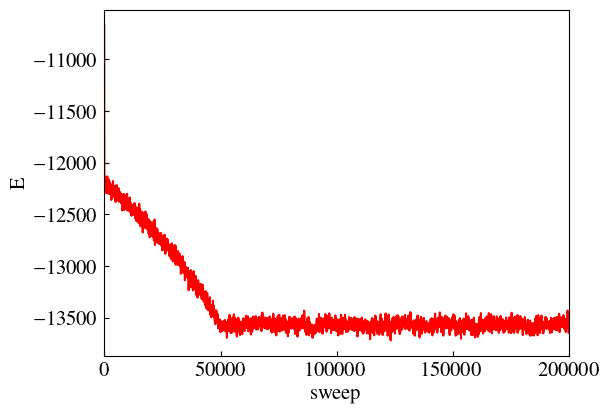

In [7]:
plt.rcParams['figure.figsize'] = (6, 4.5)
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['font.size'] = 15

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,newtxtext,newtxmath,bm}'
plt.rcParams['font.family'] = 'TeX Gyre Termes'

energy = pd.read_csv("dump/energy.dat", sep = r"\s+", skiprows = 2, dtype = np.float64, header = None)

fig, ax = plt.subplots()
ax.plot(energy[0], energy[1], c = "red")

ax.set_xlim(0, max_sweeps)
ax.set_xlabel("sweep")
ax.set_ylabel("E")
ax.tick_params(direction = 'in', color = 'black')

plt.show()

## Very rough estimate of specific heat

In [8]:
c, c_err = mc.specific_heat_bootstrap(Nsites = Nsites, Energy_list = energy[1].tolist(), offset = 2000)
print(f"T = {kT}, c = {c} +- {c_err}")

T = 0.55, c = 3.3974619812614715 +- 0.4453774508412443
